In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import fuzzy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Reds_r")
%config InlineBackend.figure_format ='retina'

# Movies Database Cleaning

In [2]:
original_movies_db = pd.read_excel('movies.xls')

In [3]:
movies_db = original_movies_db

In [4]:
# Filtering to just get 'USA' matches
#movies_db = movies_db[(movies_db['country'] == 'USA')]


# Filtering to just get 'BUDGET' not equal to 0.0
movies_db = movies_db[(movies_db['budget'] != 0.0)]


In [5]:
movies_db.loc[(movies_db['year'].isnull())]

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
199,18000000.0,J&M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454,5000000.0,A&M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1714,12000000.0,A&M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4831,6000000.0,B&W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Exclude nan rows
movies_db['name'] = movies_db['name'].str.replace('&','and').str.replace("'",' ').str.replace('-','').str.replace(',','').str.replace('.','').str.replace(':','').str.strip().str.title()

movies_db = movies_db.dropna()
movies_db.isnull().sum()

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


budget      0
company     0
country     0
director    0
genre       0
gross       0
name        0
rating      0
released    0
runtime     0
score       0
star        0
votes       0
writer      0
year        0
dtype: int64

In [7]:
# Checking column names
movies_db.columns

Index(['budget', 'company', 'country', 'director', 'genre', 'gross', 'name',
       'rating', 'released', 'runtime', 'score', 'star', 'votes', 'writer',
       'year'],
      dtype='object')

In [8]:
# Selecting the columns we want to keep
movies_db = movies_db[['name', 'budget', 'gross', 'score']]

# Renaming the columns
movies_db.columns = ['TITLE', 'BUDGET', 'REVENUE', 'IMDB SCORE']

movies_db

,TITLE,BUDGET,REVENUE,IMDB SCORE
0,Stand By Me,8000000.0,52287414.0,8.1
1,Ferris Bueller S Day Off,6000000.0,70136369.0,7.8
2,Top Gun,15000000.0,179800601.0,6.9
3,Aliens,18500000.0,85160248.0,8.4
4,Flight Of The Navigator,9000000.0,18564613.0,6.9
...,...,...,...,...
6808,Love And Friendship,3000000.0,14013564.0,6.5
6809,The Hollars,3800000.0,1016872.0,6.5
6811,Middle School The Worst Years Of My Life,8500000.0,19985196.0,6.1
6814,Risen,20000000.0,36874745.0,6.3


In [9]:
# Creating the '% BUDGET/REVENUE' column

movies_db['% BUDGET/REVENUE'] = round((movies_db['BUDGET'] / movies_db['REVENUE'] * 100), 1)

In [10]:
# Converting 'YEAR' column to 'int' type

#movies_db['YEAR'] = movies_db['YEAR'].astype('str')
#movies_db['YEAR'] = movies_db['YEAR'].apply(lambda x: x.split('.')[0])
#movies_db['YEAR'] = movies_db['YEAR'].astype('int')

In [11]:
# Changing these 2 columns to be in millions
#movies_db['BUDGET'] = round((movies_db['BUDGET'] / 1000000), 1)
#movies_db['REVENUE'] = round((movies_db['REVENUE'] / 1000000), 1)


# Filtering to just get 'REVENUE' not equal to 0.0
#movies_db = movies_db[(movies_db['REVENUE'] != 0.0)]

In [12]:
# Renaming columns to be in millions
movies_db.columns = ['TITLE', 'BUDGET', 'GROSS REVENUE', 'IMDB SCORE', '% BUDGET/REVENUE']
movies_db.head()

,TITLE,BUDGET,GROSS REVENUE,IMDB SCORE,% BUDGET/REVENUE
0,Stand By Me,8000000.0,52287414.0,8.1,15.3
1,Ferris Bueller S Day Off,6000000.0,70136369.0,7.8,8.6
2,Top Gun,15000000.0,179800601.0,6.9,8.3
3,Aliens,18500000.0,85160248.0,8.4,21.7
4,Flight Of The Navigator,9000000.0,18564613.0,6.9,48.5


In [13]:
# Final order
movies_db = movies_db[['TITLE', 'BUDGET', 'GROSS REVENUE', '% BUDGET/REVENUE', 'IMDB SCORE']]


In [14]:
movies_db.isnull().sum()

TITLE               0
BUDGET              0
GROSS REVENUE       0
% BUDGET/REVENUE    0
IMDB SCORE          0
dtype: int64

# Awards winning movies cleaning

In [15]:
url = 'https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films'
html = requests.get(url).content
soup = BeautifulSoup(html, "lxml")

# tag: tbody

table_body = soup.find_all('tbody')[0]
rows = [element.text for element in table_body.find_all('tr')]

clean_rows = [row.strip().replace('\n','  ').split('  ') for row in rows]

colnames = ['TITLE', 'YEAR', 'AWARDS', 'NOMINATIONS']
awards = pd.DataFrame(clean_rows[1:], columns = colnames)
awards

,TITLE,YEAR,AWARDS,NOMINATIONS
0,Green Book,2018,3,5
1,Bohemian Rhapsody,2018,4,5
2,Roma,2018,3,10
3,Black Panther,2018,3,7
4,The Favourite,2018,1,10
...,...,...,...,...
1294,The Yankee Doodle Mouse,1943,1,1
1295,The Yearling,1946,2,7
1296,"Yesterday, Today and Tomorrow (Ieri, oggi, dom...",1964,1,1
1297,You Can't Take It with You,1938,2,7


In [16]:
#Clean movie title
awards['TITLE'] = awards['TITLE'].str.replace('&','and').str.replace("'",' ').str.replace('-','').str.replace(',','').str.replace('.','').str.replace(':','').str.strip().str.title()
awards['TITLE'] = awards['TITLE'].apply(lambda x: x.split('(')[0])
awards['TITLE'] = awards['TITLE'].str.strip()
awards['TITLE'].unique()

array(['Green Book', 'Bohemian Rhapsody', 'Roma', ...,
       'Yesterday Today And Tomorrow', 'You Can T Take It With You',
       'Zorba The Greek'], dtype=object)

In [17]:
# Like this it matches the movies' file year range
awards = awards[(awards['YEAR'] <= '2016') & (awards['YEAR'] >= '1986')]
awards['YEAR'] = awards['YEAR'].astype('int')
awards

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TITLE,YEAR,AWARDS,NOMINATIONS
31,Moonlight,2016,3,8
32,La La Land,2016,6,14
33,Hacksaw Ridge,2016,2,6
34,Manchester By The Sea,2016,2,6
35,Arrival,2016,1,8
...,...,...,...,...
474,Down And Out In America,1986,1,1
475,The Fly,1986,1,1
476,A Greek Tragedy,1986,1,1
477,Precious Images,1986,1,1


In [18]:
# Filter awards by len

awards['AWARDS'] = awards['AWARDS'].apply(lambda x: x.split(' ')[0])

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Resetting the index, as it was starting at 31
awards.reset_index()
awards_db = awards[['TITLE', 'AWARDS', 'NOMINATIONS']]
awards_db.dtypes

TITLE          object
AWARDS         object
NOMINATIONS    object
dtype: object

# Rotten tomatoes cleaning

In [20]:
# importing file
rotten_tomatoes_original = pd.read_csv('rotten_tomatoes_movies.csv')
rotten_tomatoes_original.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,...,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",...,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3


In [21]:
# keeping only columns we need
rotten_tomatoes_db = rotten_tomatoes_original[['movie_title', 'tomatometer_rating']]
rotten_tomatoes_db.columns = ['TITLE', 'ROTTEN TOMATOES SCORE']
rotten_tomatoes_db

,TITLE,ROTTEN TOMATOES SCORE
0,Percy Jackson & the Olympians: The Lightning T...,49
1,Please Give,86
2,10,68
3,12 Angry Men (Twelve Angry Men),100
4,"20,000 Leagues Under The Sea",89
...,...,...
16633,Zoot Suit,56
16634,Zootopia,97
16635,Zorba the Greek,78
16636,Zulu,95


In [22]:
# Cleaning movie titles
rotten_tomatoes_db['TITLE'] = rotten_tomatoes_db['TITLE'].str.replace('&','and').str.replace("'",' ').str.replace('-','').str.replace(',','').str.replace('.','').str.replace(':','').str.strip().str.title()
rotten_tomatoes_db

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TITLE,ROTTEN TOMATOES SCORE
0,Percy Jackson And The Olympians The Lightning ...,49
1,Please Give,86
2,10,68
3,12 Angry Men (Twelve Angry Men),100
4,20000 Leagues Under The Sea,89
...,...,...
16633,Zoot Suit,56
16634,Zootopia,97
16635,Zorba The Greek,78
16636,Zulu,95


In [23]:
# Normalizing score
rotten_tomatoes_db['ROTTEN TOMATOES SCORE'] = rotten_tomatoes_db['ROTTEN TOMATOES SCORE'] / 10
rotten_tomatoes_db

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TITLE,ROTTEN TOMATOES SCORE
0,Percy Jackson And The Olympians The Lightning ...,4.9
1,Please Give,8.6
2,10,6.8
3,12 Angry Men (Twelve Angry Men),10.0
4,20000 Leagues Under The Sea,8.9
...,...,...
16633,Zoot Suit,5.6
16634,Zootopia,9.7
16635,Zorba The Greek,7.8
16636,Zulu,9.5


# Merge movies and awards

In [24]:
all_db = pd.merge(movies_db, awards_db, on = 'TITLE', how = 'outer')
all_db

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,AWARDS,NOMINATIONS
0,Stand By Me,8000000.0,52287414.0,15.3,8.1,NaN,NaN
1,Ferris Bueller S Day Off,6000000.0,70136369.0,8.6,7.8,NaN,NaN
2,Top Gun,15000000.0,179800601.0,8.3,6.9,1,4
3,Aliens,18500000.0,85160248.0,21.7,8.4,2,7
4,Flight Of The Navigator,9000000.0,18564613.0,48.5,6.9,NaN,NaN
...,...,...,...,...,...,...,...
4805,The Assault,NaN,NaN,NaN,NaN,1,1
4806,Down And Out In America,NaN,NaN,NaN,NaN,1,1
4807,A Greek Tragedy,NaN,NaN,NaN,NaN,1,1
4808,Precious Images,NaN,NaN,NaN,NaN,1,1


In [25]:
all_db = all_db.sort_values(['TITLE'])
all_db.reset_index()

all_db.isnull().sum()

TITLE                  0
BUDGET               185
GROSS REVENUE        185
% BUDGET/REVENUE     185
IMDB SCORE           185
AWARDS              4359
NOMINATIONS         4359
dtype: int64

In [26]:
all_db[['AWARDS', 'NOMINATIONS']] = all_db[['AWARDS', 'NOMINATIONS']].fillna(0)
all_db = all_db.reset_index()
all_db.isnull().sum()

index                 0
TITLE                 0
BUDGET              185
GROSS REVENUE       185
% BUDGET/REVENUE    185
IMDB SCORE          185
AWARDS                0
NOMINATIONS           0
dtype: int64

In [27]:
all_db = all_db.dropna()
all_db.isnull().sum()

index               0
TITLE               0
BUDGET              0
GROSS REVENUE       0
% BUDGET/REVENUE    0
IMDB SCORE          0
AWARDS              0
NOMINATIONS         0
dtype: int64

In [28]:
all_db = all_db[['TITLE', 'BUDGET', 'GROSS REVENUE','% BUDGET/REVENUE', 'IMDB SCORE', 'AWARDS', 'NOMINATIONS']]
all_db

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,AWARDS,NOMINATIONS
0,10 Cloverfield Lane,15000000.0,71897215.0,20.9,7.2,0,0
1,10 Things I Hate About You,30000000.0,38176108.0,78.6,7.2,0,0
2,10000 Bc,105000000.0,94784201.0,110.8,5.1,0,0
3,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,0,0
4,102 Dalmatians,85000000.0,66957026.0,126.9,4.8,0,0
...,...,...,...,...,...,...,...
4805,[Rec] 2,5600000.0,27766.0,20168.6,6.6,0,0
4806,[Rec] 3 Genesis,6400000.0,8973.0,71325.1,5.0,0,0
4807,°Three Amigos!,25000000.0,39246734.0,63.7,6.4,0,0
4808,Øsabes Quièn Viene?,25000000.0,2547047.0,981.5,7.2,0,0


# Merge all and rotten tomatoes

In [29]:
all_db = pd.merge(all_db, rotten_tomatoes_db, on = 'TITLE')
all_db = all_db[['TITLE', 'BUDGET', 'GROSS REVENUE', '% BUDGET/REVENUE', 'IMDB SCORE', 'ROTTEN TOMATOES SCORE', 'AWARDS', 'NOMINATIONS']]
all_db

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,AWARDS,NOMINATIONS
0,10 Cloverfield Lane,15000000.0,71897215.0,20.9,7.2,9.0,0,0
1,10 Things I Hate About You,30000000.0,38176108.0,78.6,7.2,6.8,0,0
2,10000 Bc,105000000.0,94784201.0,110.8,5.1,0.8,0,0
3,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,9.8,0,0
4,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,4.2,0,0
...,...,...,...,...,...,...,...,...
4242,Zoolander 2,50000000.0,28848693.0,173.3,4.7,2.3,0,0
4243,Zoom,35000000.0,11631245.0,300.9,4.3,0.3,0,0
4244,Zootopia,150000000.0,341268248.0,44.0,8.0,9.7,1,1
4245,[Rec] 2,5600000.0,27766.0,20168.6,6.6,6.8,0,0


In [30]:
# Drop duplicates
all_db = all_db.drop_duplicates(['TITLE'])
all_db.reset_index()
all_db

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,AWARDS,NOMINATIONS
0,10 Cloverfield Lane,15000000.0,71897215.0,20.9,7.2,9.0,0,0
1,10 Things I Hate About You,30000000.0,38176108.0,78.6,7.2,6.8,0,0
2,10000 Bc,105000000.0,94784201.0,110.8,5.1,0.8,0,0
3,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,9.8,0,0
5,102 Dalmatians,85000000.0,66957026.0,126.9,4.8,3.1,0,0
...,...,...,...,...,...,...,...,...
4242,Zoolander 2,50000000.0,28848693.0,173.3,4.7,2.3,0,0
4243,Zoom,35000000.0,11631245.0,300.9,4.3,0.3,0,0
4244,Zootopia,150000000.0,341268248.0,44.0,8.0,9.7,1,1
4245,[Rec] 2,5600000.0,27766.0,20168.6,6.6,6.8,0,0


In [31]:
all_db.duplicated(['TITLE']).sum()

0

In [32]:
# Ratio tomatoes and IMDB
all_db['IMDB-R.TOMATOES'] = all_db['IMDB SCORE'] - all_db['ROTTEN TOMATOES SCORE']
all_db = all_db[['TITLE', 'BUDGET', 'GROSS REVENUE', '% BUDGET/REVENUE', 'IMDB SCORE', 'ROTTEN TOMATOES SCORE', 'IMDB-R.TOMATOES', 'AWARDS', 'NOMINATIONS']]
all_db = all_db.reset_index(drop = True)
all_db

/Users/marie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES,AWARDS,NOMINATIONS
0,10 Cloverfield Lane,15000000.0,71897215.0,20.9,7.2,9.0,-1.8,0,0
1,10 Things I Hate About You,30000000.0,38176108.0,78.6,7.2,6.8,0.4,0,0
2,10000 Bc,105000000.0,94784201.0,110.8,5.1,0.8,4.3,0,0
3,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,9.8,-4.1,0,0
4,102 Dalmatians,85000000.0,66957026.0,126.9,4.8,3.1,1.7,0,0
...,...,...,...,...,...,...,...,...,...
3873,Zoolander 2,50000000.0,28848693.0,173.3,4.7,2.3,2.4,0,0
3874,Zoom,35000000.0,11631245.0,300.9,4.3,0.3,4.0,0,0
3875,Zootopia,150000000.0,341268248.0,44.0,8.0,9.7,-1.7,1,1
3876,[Rec] 2,5600000.0,27766.0,20168.6,6.6,6.8,-0.2,0,0


# Stats

In [33]:
stats_db = all_db.describe()
stats_db

,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES
count,3.878000e+03,3.878000e+03,3.878000e+03,3878.000000,3878.000000,3878.000000
mean,3.759698e+07,4.818629e+07,3.076580e+03,6.373053,5.246364,1.126689
std,4.040369e+07,6.593722e+07,3.603835e+04,0.983909,2.767641,2.162275
min,6.000000e+03,1.098000e+03,0.000000e+00,1.900000,0.000000,-5.500000
25%,1.100000e+07,8.085996e+06,4.980000e+01,5.800000,2.900000,-0.700000
50%,2.500000e+07,2.635285e+07,9.870000e+01,6.400000,5.300000,1.100000
75%,5.000000e+07,6.006223e+07,2.235750e+02,7.100000,7.700000,3.000000
max,2.600000e+08,7.605076e+08,1.305556e+06,9.300000,10.000000,7.000000


### Budget outliers

In [34]:
# Quartiles
budget_Q1 = stats_db['BUDGET'].loc['25%']
budget_Q3 = stats_db['BUDGET'].loc['75%']

# IQR
budget_IQR = budget_Q3 - budget_Q1

# Limits
budget_upper_limit = budget_Q3 + 1.5 * budget_IQR
budget_lower_limit = budget_Q1 - 1.5 * budget_IQR

# Removing outliers
db_no_outliers = all_db[(all_db['BUDGET'] > budget_lower_limit) & (all_db['BUDGET'] < budget_upper_limit)]

### Revenue outliers

In [35]:
# Quartiles
revenue_Q1 = stats_db['GROSS REVENUE'].loc['25%']
revenue_Q3 = stats_db['GROSS REVENUE'].loc['75%']

# IQR
revenue_IQR = revenue_Q3 - revenue_Q1

# Limits
revenue_upper_limit = revenue_Q3 + 1.5 * revenue_IQR
revenue_lower_limit = revenue_Q1 - 1.5 * revenue_IQR

# Removing outliers
db_no_outliers = all_db[(all_db['GROSS REVENUE'] > revenue_lower_limit) & (all_db['GROSS REVENUE'] < revenue_upper_limit)]

In [36]:
db_no_outliers

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES,AWARDS,NOMINATIONS
0,10 Cloverfield Lane,15000000.0,71897215.0,20.9,7.2,9.0,-1.8,0,0
1,10 Things I Hate About You,30000000.0,38176108.0,78.6,7.2,6.8,0.4,0,0
2,10000 Bc,105000000.0,94784201.0,110.8,5.1,0.8,4.3,0,0
3,101 Dalmatians,75000000.0,136189294.0,55.1,5.7,9.8,-4.1,0,0
4,102 Dalmatians,85000000.0,66957026.0,126.9,4.8,3.1,1.7,0,0
...,...,...,...,...,...,...,...,...,...
3872,Zoolander,28000000.0,45172250.0,62.0,6.6,6.4,0.2,0,0
3873,Zoolander 2,50000000.0,28848693.0,173.3,4.7,2.3,2.4,0,0
3874,Zoom,35000000.0,11631245.0,300.9,4.3,0.3,4.0,0,0
3876,[Rec] 2,5600000.0,27766.0,20168.6,6.6,6.8,-0.2,0,0


In [37]:
test = db_no_outliers.describe()

In [38]:
all_db.describe()
mean1 = (test['BUDGET'].loc['mean']) / (test['GROSS REVENUE'].loc['mean'])
mean1

0.955494567195962

In [39]:
#Bins
all_db['QUARTILES'] = pd.cut(all_db['BUDGET'], 4, labels = ['1Q', '2Q', '3Q', '4Q'])

## Plots

### All movies without outliers

#### Relation - budget and revenue

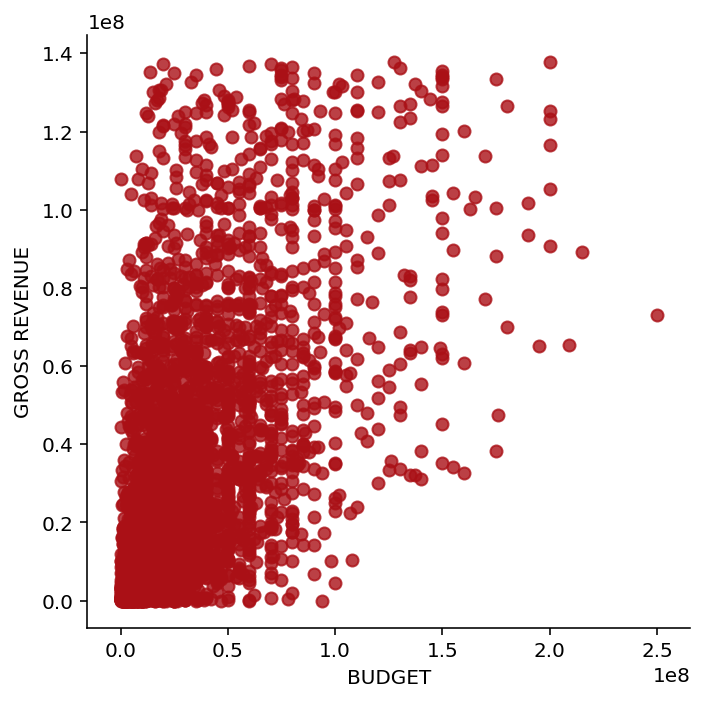

In [40]:
#Plot

db_no_outliers = db_no_outliers.sort_values(by = ['BUDGET', 'GROSS REVENUE'])
sns.lmplot(x = 'BUDGET', y = 'GROSS REVENUE', data = db_no_outliers, fit_reg = False)



In [41]:
# correlation
db_no_outliers[['BUDGET', 'GROSS REVENUE']].corr()

,BUDGET,GROSS REVENUE
BUDGET,1.00000,0.56023
GROSS REVENUE,0.56023,1.00000


#### Relation - budget and ratings

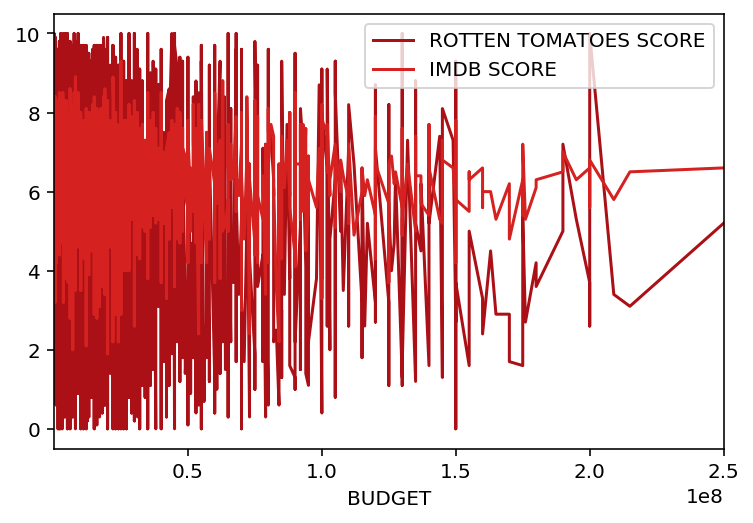

In [42]:
#Plot
db_no_outliers.plot(x = 'BUDGET', y = ['ROTTEN TOMATOES SCORE', 'IMDB SCORE'])

In [43]:
#Corr
db_no_outliers[['BUDGET', 'IMDB SCORE', 'ROTTEN TOMATOES SCORE']].corr()

,BUDGET,IMDB SCORE,ROTTEN TOMATOES SCORE
BUDGET,1.000000,-0.065440,-0.117899
IMDB SCORE,-0.065440,1.000000,0.716787
ROTTEN TOMATOES SCORE,-0.117899,0.716787,1.000000


#### Relation - budget and awards

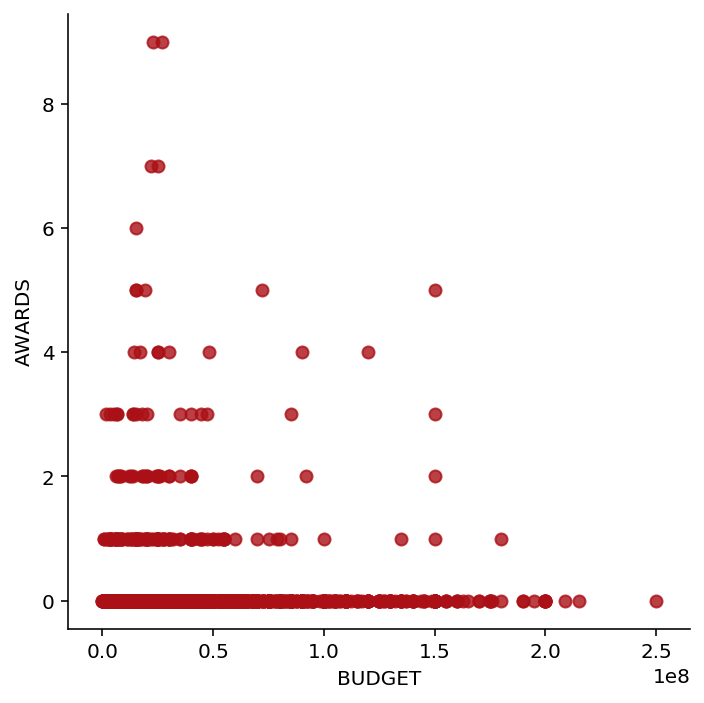

In [44]:
# Plot
db_no_outliers['AWARDS'] = db_no_outliers['AWARDS'].astype('int')
sns.lmplot(x = 'BUDGET', y = 'AWARDS', data = db_no_outliers, fit_reg = False)


In [45]:
# Corr
db_no_outliers[['BUDGET', 'AWARDS']].corr()

,BUDGET,AWARDS
BUDGET,1.000000,0.006143
AWARDS,0.006143,1.000000


### Awards movies only

In [46]:
all_db['AWARDS'] = all_db['AWARDS'].astype('int')
awards_movies = all_db[(all_db['AWARDS'] > 0)]
awards_movies.reset_index(drop=True)

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES,AWARDS,NOMINATIONS,QUARTILES
0,12 Years A Slave,20000000.0,56671993.0,35.3,8.1,9.5,-1.4,3,9,1Q
1,8 Mile,41000000.0,116724075.0,35.1,7.0,7.5,-0.5,1,1,1Q
2,A Beautiful Mind,58000000.0,170742341.0,34.0,8.2,7.4,0.8,4,8,1Q
3,A Fish Called Wanda,7500000.0,63493712.0,11.8,7.6,9.4,-1.8,1,3,1Q
4,A Separation,500000.0,7098492.0,7.0,8.4,9.9,-1.5,1,2,1Q
...,...,...,...,...,...,...,...,...,...,...
238,Who Framed Roger Rabbit,70000000.0,156452370.0,44.7,7.7,9.7,-2.0,3,6,2Q
239,Wonder Boys,55000000.0,19389454.0,283.7,7.4,8.2,-0.8,1,3,1Q
240,Working Girl,28000000.0,64000000.0,43.8,6.7,8.3,-1.6,1,6,1Q
241,Zero Dark Thirty,40000000.0,95720716.0,41.8,7.4,9.1,-1.7,1,5,1Q


In [47]:
awards_movies

,TITLE,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES,AWARDS,NOMINATIONS,QUARTILES
6,12 Years A Slave,20000000.0,56671993.0,35.3,8.1,9.5,-1.4,3,9,1Q
41,8 Mile,41000000.0,116724075.0,35.1,7.0,7.5,-0.5,1,1,1Q
47,A Beautiful Mind,58000000.0,170742341.0,34.0,8.2,7.4,0.8,4,8,1Q
56,A Fish Called Wanda,7500000.0,63493712.0,11.8,7.6,9.4,-1.8,1,3,1Q
91,A Separation,500000.0,7098492.0,7.0,8.4,9.9,-1.5,1,2,1Q
...,...,...,...,...,...,...,...,...,...,...
3796,Who Framed Roger Rabbit,70000000.0,156452370.0,44.7,7.7,9.7,-2.0,3,6,2Q
3830,Wonder Boys,55000000.0,19389454.0,283.7,7.4,8.2,-0.8,1,3,1Q
3833,Working Girl,28000000.0,64000000.0,43.8,6.7,8.3,-1.6,1,6,1Q
3867,Zero Dark Thirty,40000000.0,95720716.0,41.8,7.4,9.1,-1.7,1,5,1Q


#### Relation - Budget and gross revenue 

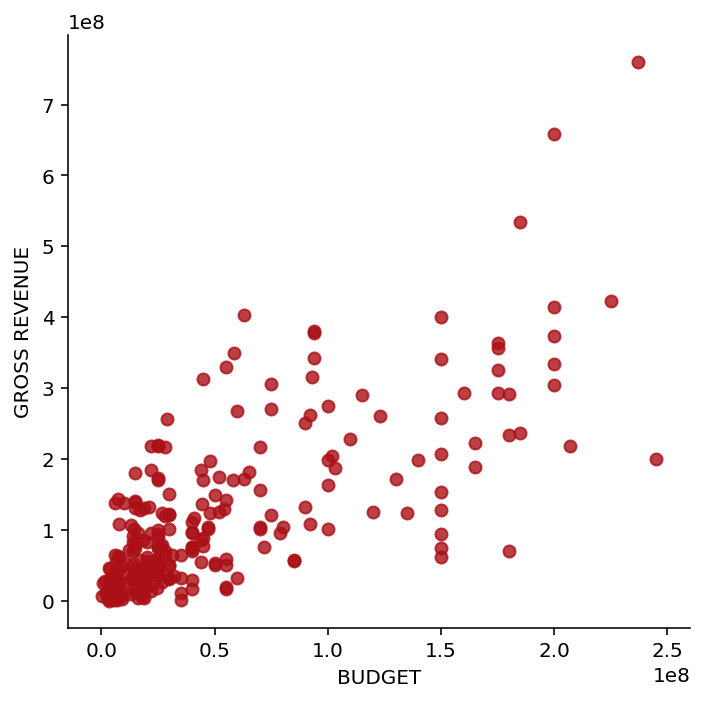

In [48]:
# plot
awards_movies = awards_movies.sort_values(by = ['BUDGET', 'GROSS REVENUE'])
sns.lmplot(x = 'BUDGET', y = 'GROSS REVENUE', data = awards_movies, fit_reg = False)

In [49]:
# correlation
awards_movies[['BUDGET', 'GROSS REVENUE']].corr()

,BUDGET,GROSS REVENUE
BUDGET,1.000000,0.728092
GROSS REVENUE,0.728092,1.000000


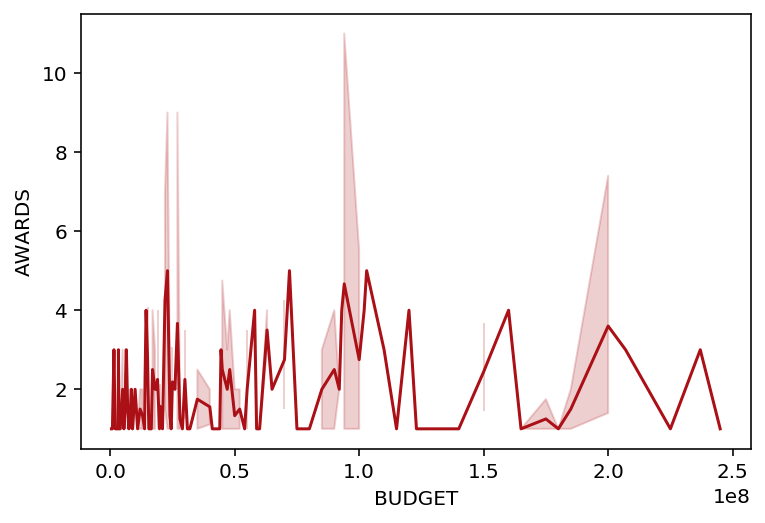

In [50]:
sns.lineplot(data = awards_movies, x = 'BUDGET', y = 'AWARDS')

In [51]:
awards_movies.describe()

,BUDGET,GROSS REVENUE,% BUDGET/REVENUE,IMDB SCORE,ROTTEN TOMATOES SCORE,IMDB-R.TOMATOES,AWARDS
count,2.430000e+02,2.430000e+02,243.00000,243.000000,243.000000,243.000000,243.000000
mean,5.288021e+07,1.192848e+08,109.45144,7.606173,8.345679,-0.739506,2.049383
std,5.606663e+07,1.174002e+08,476.60049,0.620919,1.446773,1.255732,1.776113
min,5.000000e+05,5.455600e+04,3.60000,5.600000,2.400000,-4.000000,1.000000
25%,1.500000e+07,3.529677e+07,24.55000,7.200000,7.850000,-1.600000,1.000000
50%,2.800000e+07,7.732442e+07,41.90000,7.700000,8.800000,-1.000000,1.000000
75%,7.000000e+07,1.707149e+08,70.15000,8.000000,9.300000,-0.300000,2.000000
max,2.450000e+08,7.605076e+08,5865.50000,9.000000,10.000000,5.400000,11.000000


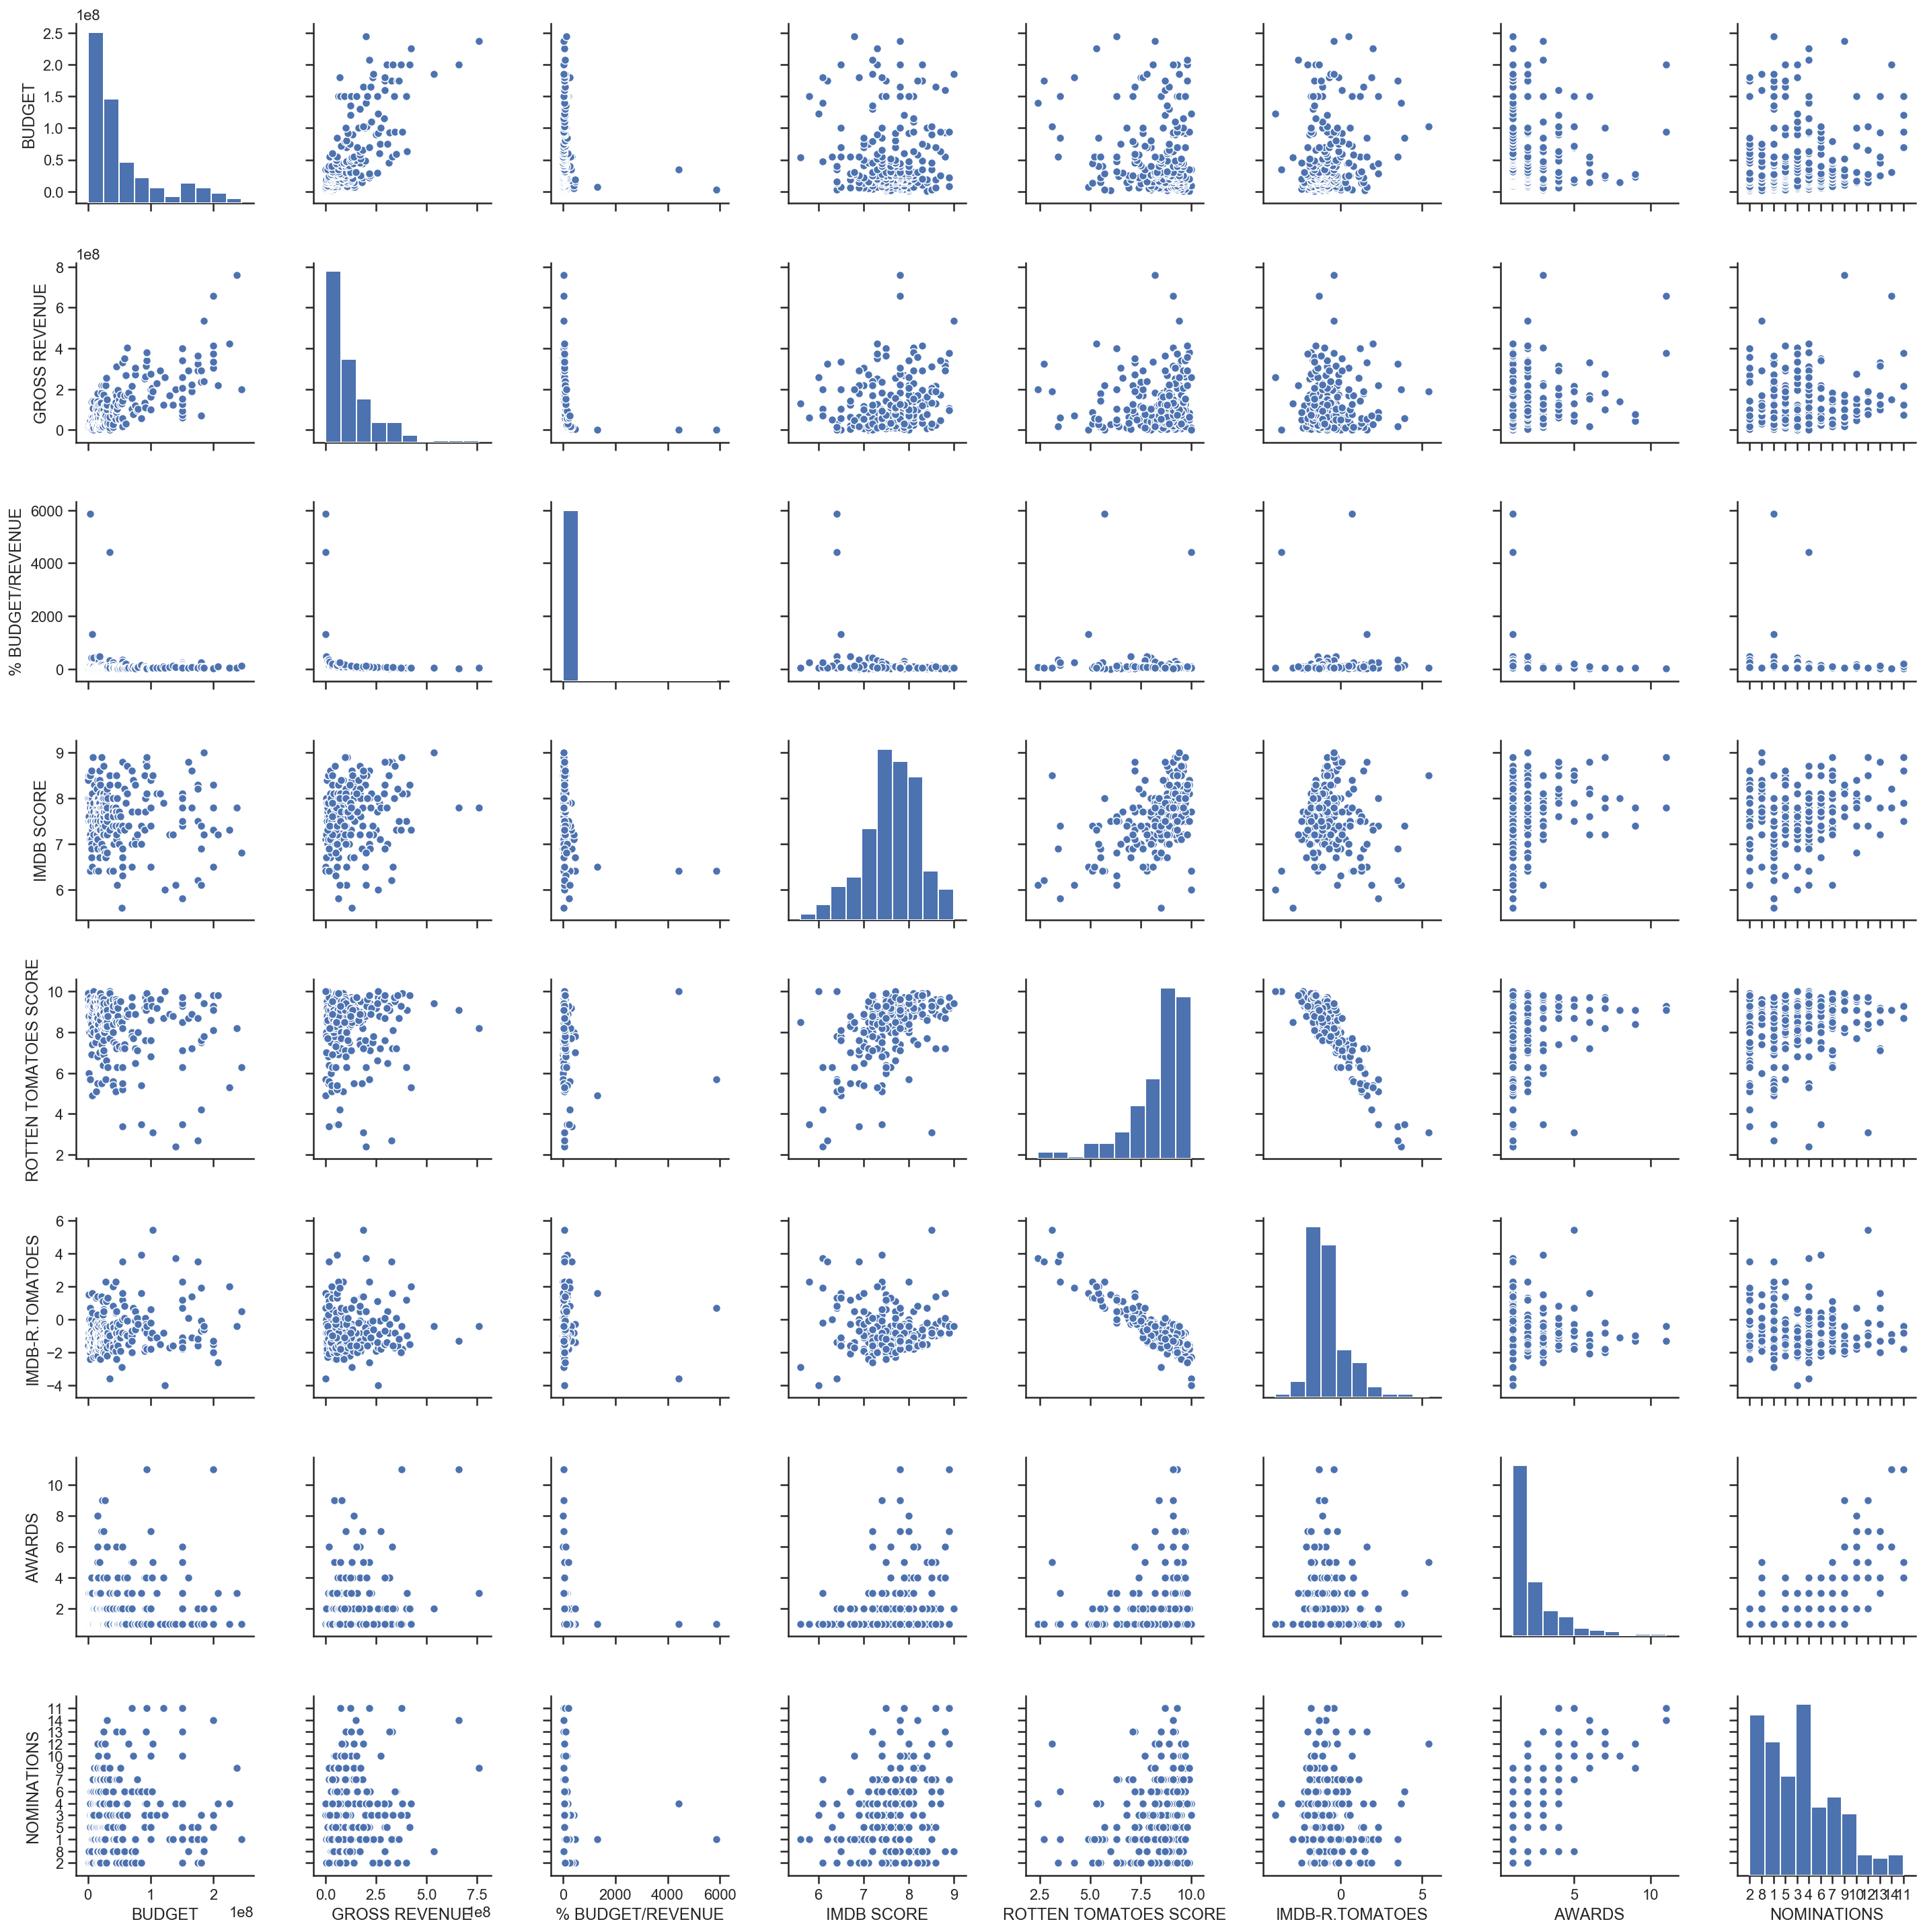

In [52]:
sns.set(style='ticks')
sns.pairplot(awards_movies)